<a href="https://colab.research.google.com/github/francescoasaro/IGARSS21/blob/main/notebooks/IGARSS21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Deep Models from Weak Labels for Water Surface Segmentation in SAR Images.

* [Paper](https://ieeexplore.ieee.org/abstract/document/9554647)
* [GitHub repo](https://github.com/francescoasaro/IGARSS21)
* [Test data and architecture weights](https://zenodo.org/record/5707779)

This notebook is designed for showing interactively the results from the paper *Learning Deep Models from Weak Labels for Water Surface Segmentation in SAR Images* by Asaro et al. presented at IGARSS21.

## Downloads

In this cell you will:

* install zenodo-get 
* download the test data and architecture weights from Zenodo
* clone the architecture model from GitHub

In [ ]:
!pip install zenodo-get
!zenodo_get 5707779
!git clone https://github.com/francescoasaro/IGARSS21

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=940fb4c2d8619b41419c8350da7d2869a0a09cb1bf12d4bce4f5ed06d5cb31f7
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Title: Learning Deep Models from Weak Labels for Water Surface Segmentation in SAR Images
Keywords: Deep Learning, Flood Mapping, Synthetic Aperture RADAR
Publication date: 2021-10-12
DOI: 10.1109/IGARSS47720.2021.9554647
Total size: 46.7 MB

Link: https://zenodo.org/api/files/c24dcda4-4910-4930-b14b-0a7506cab3d6/IGARSS21_samples.npy   size: 14.1 MB

Checksum is correct. (ea5eef63bbd1a9b04e89c8f1d624caac)

Link: https://zenodo.org/api/files/c24dcda4-4910-4930-b14b-0a7506cab3d6/IGARSS21_weights.pth   size: 32.7 MB

Checksum is correct. (6ec8618ec3562072e7d266f899b393af)
All files have been downloaded.
Cloning into 'IGARSS21'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote

## Imports

In [ ]:
import ee
import time
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./IGARSS21/code')
from model import  BaselineUnet4

## Convenience functions

In [127]:
def get_random_sample(samples:list, device = 'cpu'):
  '''
  Gets a random sample from the test data and prepares it for inference.
  '''
  idx = random.choice(range(0,len(samples)))
  input = samples[idx][0]
  tensor = torch.tensor(input)
  tensor = tensor.to(device)
  tensor = tensor.unsqueeze(0)
  
  return tensor, samples[idx]


def get_data_from_collection(im_col, idx: int, x_off = 0, y_off = 0, patch_size = 128, clip_value = 1, scale = 100):
  '''
  Extracts an inference ready patch from a GEE ImageCollection.
  '''

  im_list = im_col.toList(im_col.size())
  im = ee.Image(im_list.get(idx)).sampleRectangle(region=aoi)
  vh_band = np.array(im.get('VH').getInfo())
  vv_band = np.array(im.get('VV').getInfo())
  data = np.stack((vh_band,vv_band), axis=0)

  data = data[:, x_off:x_off + patch_size, y_off:y_off + patch_size]
  data = np.float32(data)
  data[data >= clip_value] = clip_value
  data = data*scale

  tensor = torch.tensor(data)
  tensor = tensor.unsqueeze(0)
  tensor = tensor.to(device)

  return tensor, data


def get_prediction(tensor:torch.tensor, model):
  '''
  Given an input tensor and a model, returns the prediction.
  '''

  softmax = nn.Softmax2d()
  logits = model(tensor)
  prediction = softmax(logits).squeeze(0)
  prediction = torch.argmax(prediction, axis=0)
  prediction = prediction.detach().cpu().numpy()

  return prediction


def plot_prediction(sample:tuple, prediction:np.array, nodata_value = None):
  '''
  Plots VH and VH bands, label and prediction.
  '''
  
  fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,20))
  ax[0].imshow(sample[0][0,:,:],vmin=0,vmax=20,cmap='gray')
  ax[0].set_title('VH polarization intensity',fontsize=20)
  ax[1].imshow(sample[0][1,:,:],vmin=0,vmax=50,cmap='gray')
  ax[1].set_title('VV polarization intensity', fontsize=20)
  label = np.float32(sample[1])
  prediction = np.float32(prediction)
  if nodata_value:
    mask = (label== nodata_value)
    label[mask] = np.nan
    prediction[mask] = np.nan
  ax[2].imshow(label,vmin=0,vmax=1,cmap='Blues')
  ax[2].set_title('Aggregated Copernicus HRL', fontsize=20)
  ax[3].imshow(prediction,vmin=0,vmax=1,cmap='Blues')
  ax[3].set_title('Inference', fontsize=20)

  return

## Preparing the model

In this cell you will: 

*   Find the available device (GPU or CPU)
*   Initialize the model architecture
*   Load the model weights
*   Configure the model for inference



In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = "cpu"

model = BaselineUnet4(2,2) #the model produces dummy multiclass logits (two classes water and land) as result of a trick for handling no data within the patches during training. 
model = nn.DataParallel(model)
checkpoint = torch.load('./IGARSS21_weights.pth',map_location = device)
model.load_state_dict(checkpoint) 
model.eval()  
model.to(device)

DataParallel(
  (module): BaselineUnet4(
    (conv_encode1): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test on provided sample patches

In the following cells you will: 

*   Load the provided sample dataset
*   Run inference with the model
*   Plot the results

**These patches have been extracted from the validation area, thus the model did not have "seen" them during training**



In [ ]:
# load examples
examples = np.load('./IGARSS21_samples.npy',allow_pickle = True)

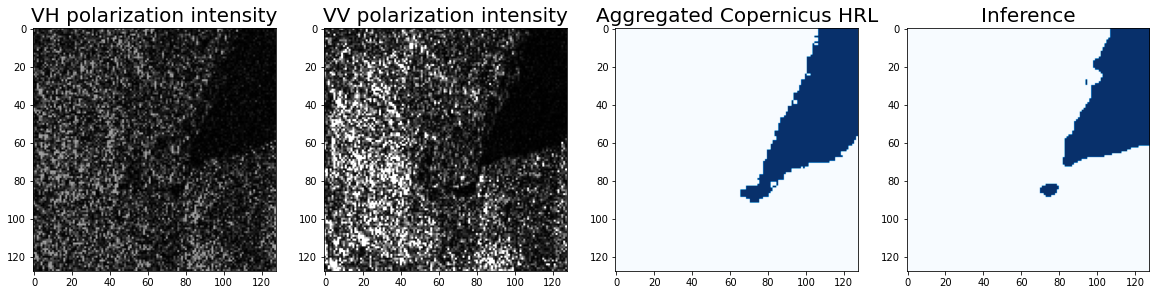

In [ ]:
# inference
tensor,sample = get_random_sample(examples,device = device)
pred = get_prediction(tensor, model)
plot_prediction(sample,pred)

## Test on GRDs from EE

In the following cells you will:

* Authorize access to GEEE
* Define a GeoJSON AOI
* Extract a "datacube" from GEE for the AoI and a given temporal horizon 
* Run inference with the model along the whole temporal horizon of the "datacube"

Authentication

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=JHh76EQAq0zTxPDq84IsPEZI-GQknq_bPAfRL29ZtV0&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjluo5b0-itQA6udoOFNmm7QA2wXWybyJvf0m2FP_FSMSd5w87nh08

Successfully saved authorization token.


This default AoI covers a segment of the Po river in Italy. You can define your AoI in GeoJSON format [here](https://geojson.io/)!


In [119]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.752498626708984,
              45.00000978550155
            ],
            [
              8.793182373046875,
              45.00000978550155
            ],
            [
              8.793182373046875,
              45.01700087181393
            ],
            [
              8.752498626708984,
              45.01700087181393
            ],
            [
              8.752498626708984,
              45.00000978550155
            ]
          ]
        ]
      }
    }
  ]
}

coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

"Datacube" extraction

In [133]:
im_col = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT').filterBounds(aoi).filterDate(ee.Date('2021-01-01'), ee.Date('2021-01-31')))
acq_times = im_col.aggregate_array('system:time_start').getInfo()
acq_times = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

Inference and results plot

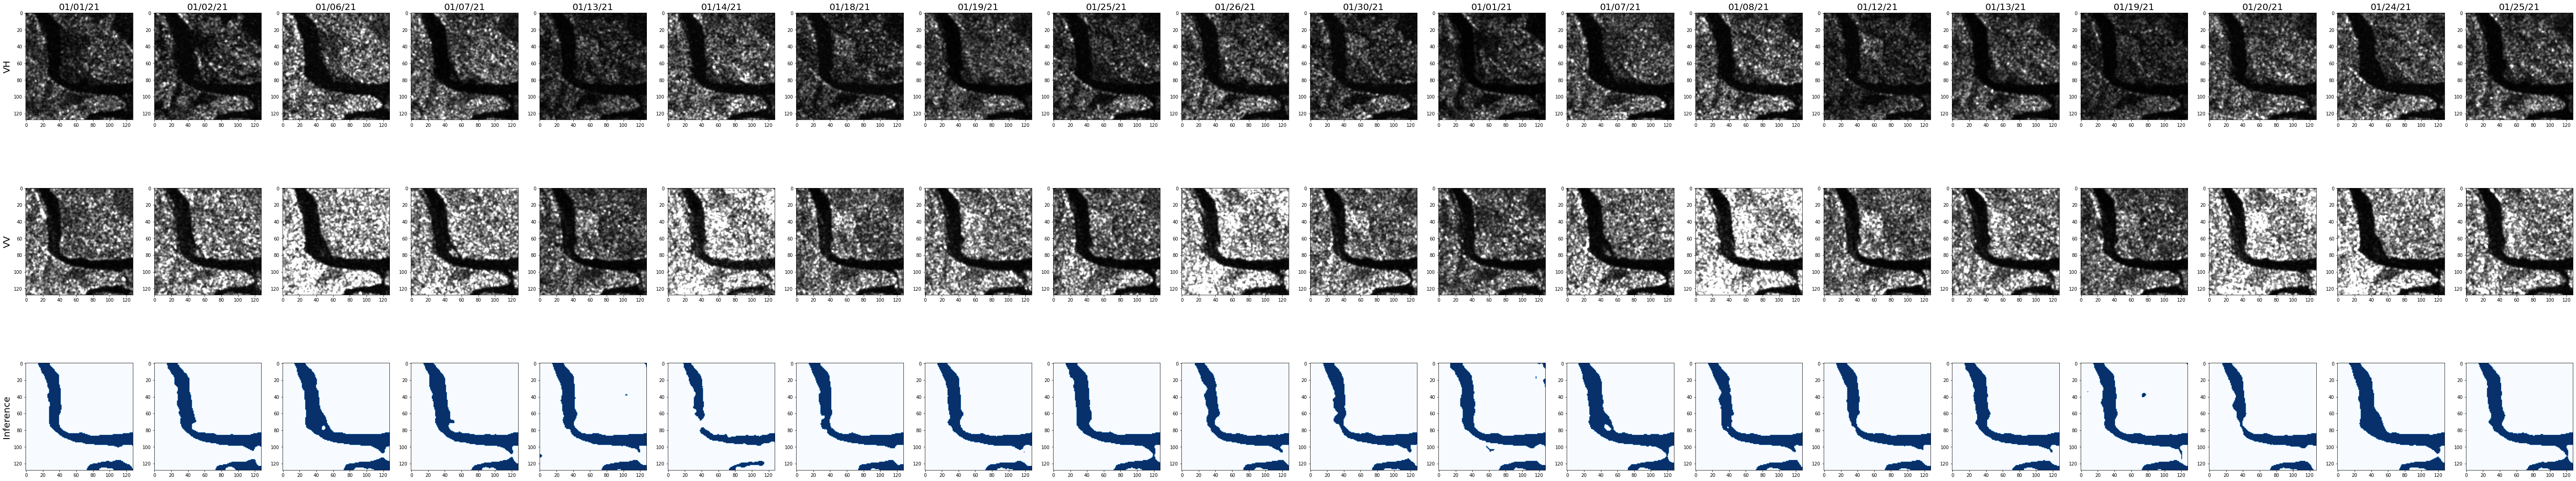

In [138]:
fig, ax = plt.subplots(nrows=3,ncols=len(acq_times),figsize=(100,20))

ax[0,0].set_ylabel(f'VH',fontsize = 20)
ax[1,0].set_ylabel(f'VV',fontsize = 20)
ax[2,0].set_ylabel(f'Inference ',fontsize = 20)

for idx in range(0,len(acq_times)):
  
  tensor, data = get_data_from_collection(im_col, idx)
  pred = get_prediction(tensor,model)

  date = acq_times[idx]
  ax[0, idx].set_title(date, fontsize = 20)

  ax[0,idx].imshow(data[0,:,:], vmin = 0, vmax = 10, cmap = 'gray')
  ax[1,idx].imshow(data[1,:,:], vmin = 0, vmax = 20, cmap = 'gray') 
  ax[2,idx].imshow(pred, vmin = 0, vmax = 1, cmap = 'Blues') 